<a href="https://colab.research.google.com/github/eric-fey-hus/ukko/blob/main/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transforme model for tabular timecourse data

## Basic attention model with residual connections

In [1]:
# attention model with residual connectoin
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(-2)]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        seq_len = query.size(1)

        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)

        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attention_weights = torch.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        output = torch.matmul(attention_weights, V)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.W_o(output)

        return output, attention_weights

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, x):
        return self.linear2(self.dropout(self.activation(self.linear1(x))))

class DualAttentionModel(nn.Module):
    def __init__(self, n_features, time_steps, d_model=128, n_heads=8, dropout=0.1):
        super().__init__()

        self.d_model = d_model

        # Input projection
        self.input_projection = nn.Linear(1, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)

        # Feature attention block
        self.feature_attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feature_norm = nn.LayerNorm(d_model)
        self.feature_ff = FeedForward(d_model, dropout=dropout)
        self.feature_ff_norm = nn.LayerNorm(d_model)

        # Time attention block
        self.time_attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.time_norm = nn.LayerNorm(d_model)
        self.time_ff = FeedForward(d_model, dropout=dropout)
        self.time_ff_norm = nn.LayerNorm(d_model)

        # Output layers with residual connection
        self.output_ff = FeedForward(d_model, dropout=dropout)
        self.output_norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: [batch_size, n_features, time_steps]
        batch_size, n_features, time_steps = x.shape

        # Add channel dimension and project
        x = x.unsqueeze(-1)  # [batch_size, n_features, time_steps, 1]
        x = self.input_projection(x)  # [batch_size, n_features, time_steps, d_model]

        # Add positional encoding
        x = self.pos_encoder(x)

        # Feature attention block with residual connections
        # Reshape for feature attention
        x_feat = x.transpose(1, 2).reshape(batch_size * time_steps, n_features, self.d_model)
        identity = x_feat

        # Feature attention
        x_feat, feat_weights = self.feature_attention(x_feat, x_feat, x_feat)
        x_feat = identity + self.dropout(x_feat)  # First residual connection
        x_feat = self.feature_norm(x_feat)

        # Feature feed-forward
        identity = x_feat
        x_feat = identity + self.dropout(self.feature_ff(x_feat))  # Second residual connection
        x_feat = self.feature_ff_norm(x_feat)

        # Reshape back
        x = x_feat.view(batch_size, time_steps, n_features, self.d_model).transpose(1, 2)

        # Time attention block with residual connections
        # Reshape for time attention
        x_time = x.reshape(batch_size * n_features, time_steps, self.d_model)
        identity = x_time

        # Time attention
        x_time, time_weights = self.time_attention(x_time, x_time, x_time)
        x_time = identity + self.dropout(x_time)  # Third residual connection
        x_time = self.time_norm(x_time)

        # Time feed-forward
        identity = x_time
        x_time = identity + self.dropout(self.time_ff(x_time))  # Fourth residual connection
        x_time = self.time_ff_norm(x_time)

        # Reshape back
        x = x_time.view(batch_size, n_features, time_steps, self.d_model)

        # Global average pooling over time
        x = x.mean(dim=2)  # [batch_size, n_features, d_model]

        # Final feed-forward with residual connection
        identity = x
        x = identity + self.dropout(self.output_ff(x))  # Fifth residual connection
        x = self.output_norm(x)

        # Final projection
        x = self.fc(x).squeeze(-1)  # [batch_size, n_features]

        return x, feat_weights, time_weights

def test_model():
    # Example dimensions
    batch_size = 32
    n_features = 15
    time_steps = 10

    # Create random input data
    x = torch.randn(batch_size, n_features, time_steps)

    # Initialize model
    model = DualAttentionModel(
        n_features=n_features,
        time_steps=time_steps,
        d_model=128,
        n_heads=8,
        dropout=0.1
    )

    # Forward pass
    output, feat_attn, time_attn = model(x)

    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Feature attention weights shape: {feat_attn.shape}")
    print(f"Time attention weights shape: {time_attn.shape}")

    return model, output, feat_attn, time_attn

#if __name__ == "__main__":
model, output, feat_attn, time_attn = test_model()

Input shape: torch.Size([32, 15, 10])
Output shape: torch.Size([32, 15])
Feature attention weights shape: torch.Size([320, 8, 15, 15])
Time attention weights shape: torch.Size([480, 8, 10, 10])


## Test data sine wave

/tmp/ericfey1/27114675/ipykernel_541784/1561034413.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  self.data = torch.FloatTensor(data)  # [n_samples, n_features, sequence_length + prediction_length]


Input shape: torch.Size([32, 3, 32])
Target shape: torch.Size([32, 3])
Output shape: torch.Size([32, 3])


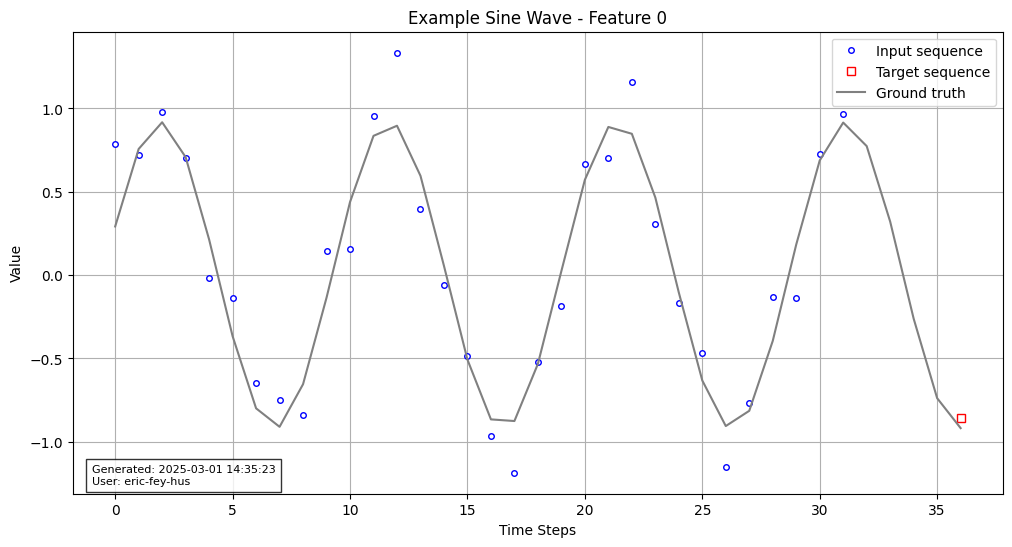

In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from datetime import datetime

class SineWaveDataset(Dataset):
    def __init__(self, n_samples, n_features, sequence_length, prediction_length=5,
                 base_freq=0.1, noise_level=0.2, seed=42):
        """
        Creates sine wave dataset with different phases and amplitudes for each feature

        Args:
            n_samples: Number of samples in dataset
            n_features: Number of features
            sequence_length: Length of input sequence
            prediction_length: Length of sequence to predict
            base_freq: Base frequency of sine waves
            noise_level: Standard deviation of Gaussian noise
        """
        np.random.seed(seed)
        torch.manual_seed(seed)

        self.sequence_length = sequence_length
        self.prediction_length = prediction_length

        # Create time points
        t = np.linspace(0, (sequence_length + prediction_length) * 2 * np.pi,
                       sequence_length + prediction_length)

        # Generate data for each sample
        data = []
        groundtruth = []
        for _ in range(n_samples):
            sample = []
            groundtruthsample = []
            for f in range(n_features):
                # Random phase and amplitude for each feature
                phase = np.random.uniform(0, 2 * np.pi)
                amplitude = np.random.uniform(0.5, 2.0)

                # Generate sine wave with noise
                sine_wave = amplitude * np.sin(base_freq * t + phase)
                noise = np.random.normal(0, noise_level, len(t))
                feature_data = sine_wave + noise

                sample.append(feature_data)
                groundtruthsample.append(sine_wave)
            data.append(sample)
            groundtruth.append(groundtruthsample)

        # Convert to torch tensors
        self.data = torch.FloatTensor(data)  # [n_samples, n_features, sequence_length + prediction_length]
        self.groundtruth = torch.FloatTensor(groundtruth)

    def __len__(self):
        return len(self.data)

    # data with noise
    def __getitem__(self, idx):
        x = self.data[idx, :, :self.sequence_length]
        #y = self.data[idx, :, self.sequence_length:self.sequence_length + self.prediction_length]
        y = self.data[idx, :, self.sequence_length + self.prediction_length -1]
        return x, y

    # groundtruth data:
    def __getgtitem__(self, idx):
        x = self.groundtruth[idx, :, :self.sequence_length]
        y = self.groundtruth[idx, :, self.sequence_length:self.sequence_length + self.prediction_length]
        return x, y

def plot_example(dataset, sample_idx=0, feature_idx=0):
    """Plot an example from the dataset with markers"""
    x, y = dataset[sample_idx]
    xgt, ygt = dataset.__getgtitem__(sample_idx)

    plt.figure(figsize=(12, 6))

    # Plot data sample with noise
    # Plot input sequence with markers
    plt.plot(range(len(x[feature_idx])), x[feature_idx],
             'o', label='Input sequence', color='blue',
             markersize=4, markerfacecolor='white', markeredgewidth=1)

    # Plot target sequence with different markers
    #plt.plot(range(len(x[feature_idx]), len(x[feature_idx]) + len(y[feature_idx])),
    #         y[feature_idx], 's', label='Target sequence', color='red',
    #         markersize=6, markerfacecolor='white', markeredgewidth=1)
    plt.plot(len(x[feature_idx]) + 5 - 1,
             y[feature_idx], 's', label='Target sequence', color='red',
             markersize=6, markerfacecolor='white', markeredgewidth=1)

    # Plot groundtruth wave
    xygt = torch.cat((xgt, ygt), dim=1)[feature_idx]
    plt.plot(range(len(xygt)), xygt,
             '-', label='Ground truth', color='gray',
             markersize=0, markerfacecolor='white', markeredgewidth=1)


    plt.title(f'Example Sine Wave - Feature {feature_idx}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    # Add timestamp and user info
    timestamp = "2025-03-01 14:35:23"
    user = "eric-fey-hus"
    plt.text(0.02, 0.02, f'Generated: {timestamp}\nUser: {user}',
             transform=plt.gca().transAxes, fontsize=8,
             bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

def create_data_loaders(batch_size=32, n_samples=1000, n_features=15,
                       sequence_length=100, prediction_length=5):
    """Create train, validation, and test data loaders"""

    # Create datasets
    train_dataset = SineWaveDataset(n_samples, n_features, sequence_length, prediction_length)
    val_dataset = SineWaveDataset(n_samples//5, n_features, sequence_length, prediction_length, seed=43)
    test_dataset = SineWaveDataset(n_samples//5, n_features, sequence_length, prediction_length, seed=44)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def test_model_with_sine_data():
    # Parameters
    batch_size = 32
    n_samples = 1000
    n_features = 3
    sequence_length = 32
    prediction_length = 5

    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        batch_size=batch_size,
        n_samples=n_samples,
        n_features=n_features,
        sequence_length=sequence_length,
        prediction_length=prediction_length
    )

    # Initialize model
    model = DualAttentionModel(
        n_features=n_features,
        time_steps=sequence_length,
        d_model=128,
        n_heads=8,
        dropout=0.1
    )

    # Test forward pass
    x, y = next(iter(train_loader))
    output, feat_attn, time_attn = model(x)

    print(f"Input shape: {x.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Output shape: {output.shape}")

    # Plot example
    dataset = SineWaveDataset(n_samples, n_features, sequence_length, prediction_length)
    plot_example(dataset, sample_idx=1)

    return model, train_loader, val_loader, test_loader

#if __name__ == "__main__":
model, train_loader, val_loader, test_loader = test_model_with_sine_data()

In [3]:
for x, y in val_loader:
  print(x.shape)
  print(y.shape)

torch.Size([32, 3, 32])
torch.Size([32, 3])
torch.Size([32, 3, 32])
torch.Size([32, 3])
torch.Size([32, 3, 32])
torch.Size([32, 3])
torch.Size([32, 3, 32])
torch.Size([32, 3])
torch.Size([32, 3, 32])
torch.Size([32, 3])
torch.Size([32, 3, 32])
torch.Size([32, 3])
torch.Size([8, 3, 32])
torch.Size([8, 3])


In [4]:
dataset = SineWaveDataset(n_samples=5, n_features=3, sequence_length=5, prediction_length=2)
print(dataset[0][0])
print(dataset[0][1])
print(torch.cat(dataset[0],dim=1))
type(torch.cat(dataset[0],dim=1))

tensor([[ 1.4954,  0.4110, -1.2546, -1.9483, -1.3025],
        [ 0.8136,  0.7878,  0.0112, -0.4989, -0.7352],
        [ 1.3061,  0.5238, -0.1538, -1.1026, -1.1568]])
tensor([ 0.7756, -0.4612, -0.2820])


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

Input shape: torch.Size([32, 3, 32])
Target shape: torch.Size([32, 3])
Output shape: torch.Size([32, 3])


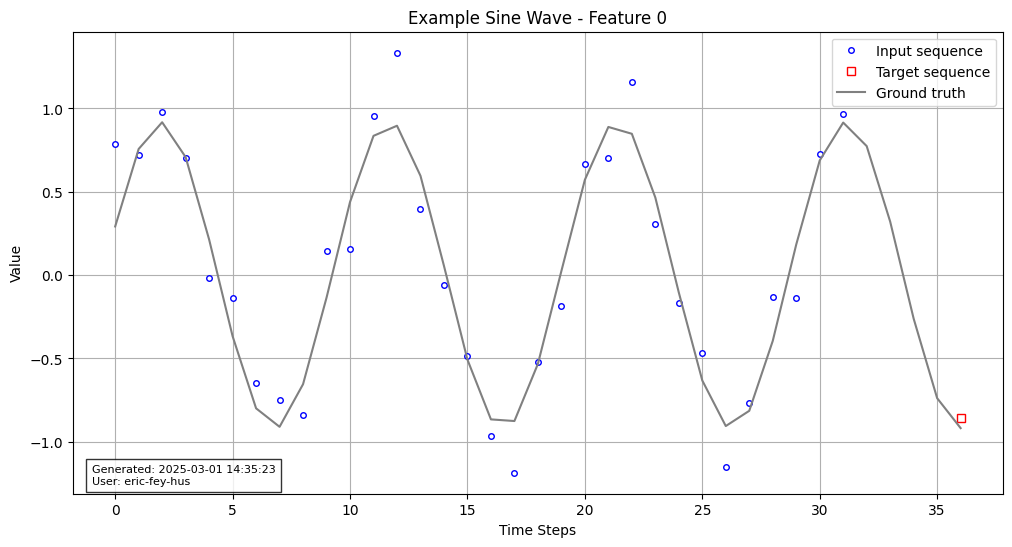

Epoch 1/50
Train Loss: 2.4405
Val Loss: 0.9768
Epoch 2/50
Train Loss: 0.9506
Val Loss: 0.9806
Epoch 3/50
Train Loss: 0.9569
Val Loss: 0.9504
Epoch 4/50
Train Loss: 0.8967
Val Loss: 0.4820
Epoch 5/50
Train Loss: 0.2093
Val Loss: 0.0786
Epoch 6/50
Train Loss: 0.0756
Val Loss: 0.0536
Epoch 7/50
Train Loss: 0.0658
Val Loss: 0.0734
Epoch 8/50
Train Loss: 0.0636
Val Loss: 0.0583
Epoch 9/50
Train Loss: 0.0602
Val Loss: 0.0481
Epoch 10/50
Train Loss: 0.0606
Val Loss: 0.0532
Epoch 11/50
Train Loss: 0.0581
Val Loss: 0.0487
Epoch 12/50
Train Loss: 0.0572
Val Loss: 0.0598
Epoch 13/50
Train Loss: 0.0598
Val Loss: 0.0724
Epoch 14/50
Train Loss: 0.0552
Val Loss: 0.0631
Epoch 15/50
Train Loss: 0.0558
Val Loss: 0.0451
Epoch 16/50
Train Loss: 0.0547
Val Loss: 0.0546
Epoch 17/50
Train Loss: 0.0553
Val Loss: 0.0519
Epoch 18/50
Train Loss: 0.0532
Val Loss: 0.0742
Epoch 19/50
Train Loss: 0.0549
Val Loss: 0.0445
Epoch 20/50
Train Loss: 0.0538
Val Loss: 0.0631
Epoch 21/50
Train Loss: 0.0503
Val Loss: 0.0498
E

In [5]:
def train_sine_model(model, train_loader, val_loader, epochs=50, lr=0.001, device='cuda'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            output, _, _ = model(x)
            #loss = criterion(output, y[:, :, 0])  # Compare with first time step of prediction
            loss = criterion(output, y)  # y is only one timepoint 5 or 4 steps ahead

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output, _, _ = model(x)
                #val_loss += criterion(output, y[:, :, 0]).item()
                val_loss += criterion(output, y).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_sine_model.pt')

# Train the model
model, train_loader, val_loader, test_loader = test_model_with_sine_data()
train_sine_model(model, train_loader, val_loader)

/tmp/ericfey1/27114675/ipykernel_541784/255876493.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_sine_model.pt'))


Loaded best model weights successfully!
Test Set Metrics:
Average MSE: 0.0444
Average MAE: 0.1695
RMSE: 0.2106


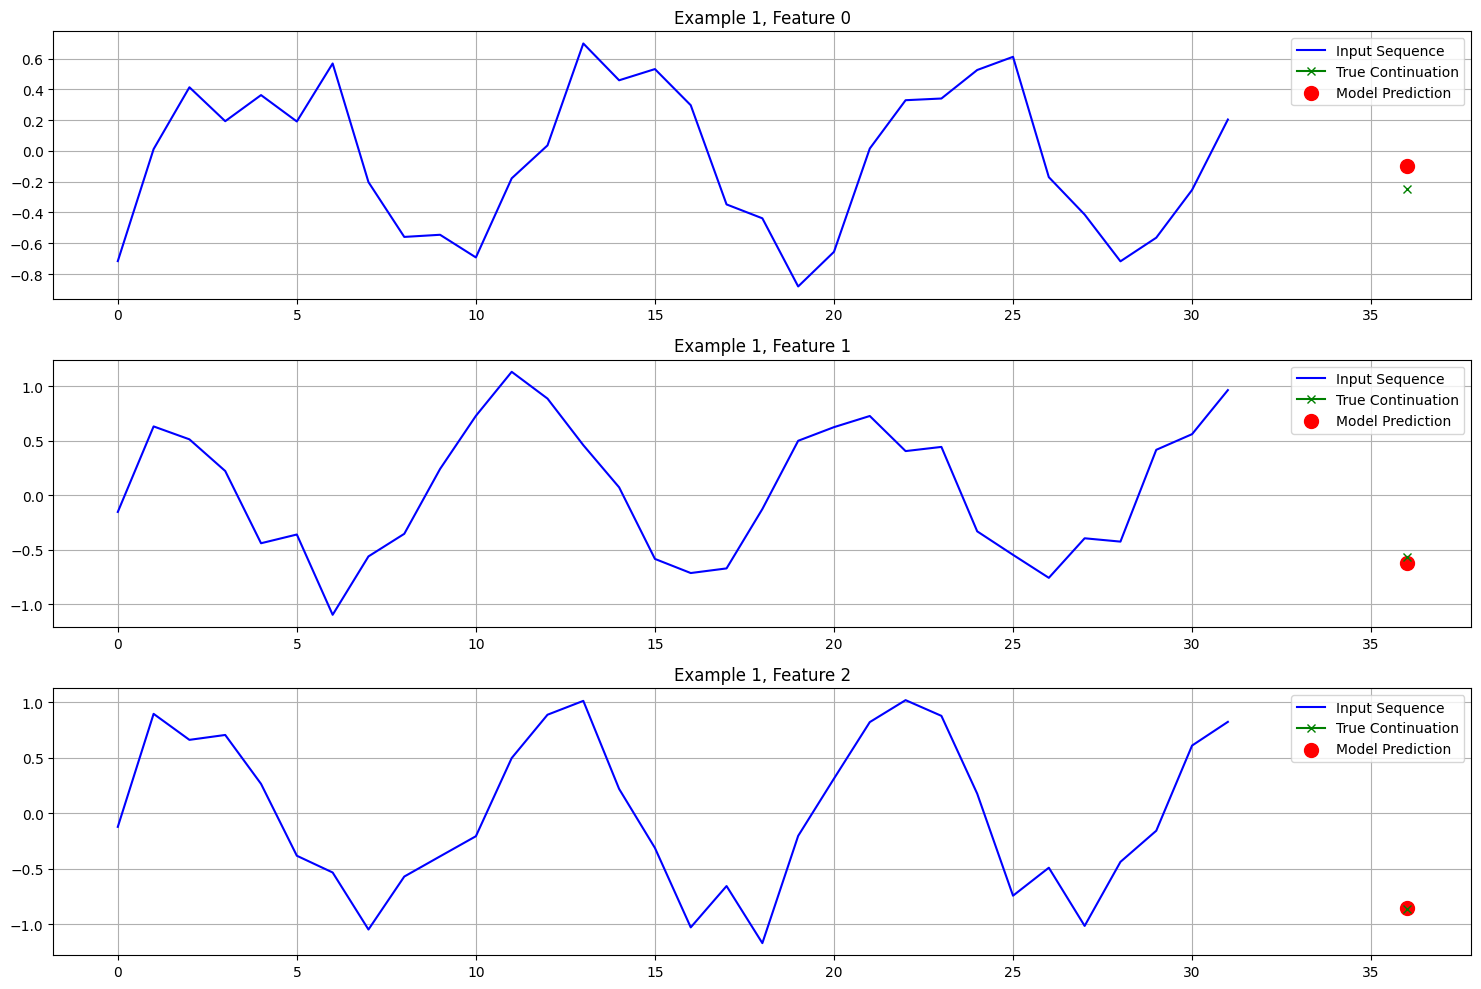

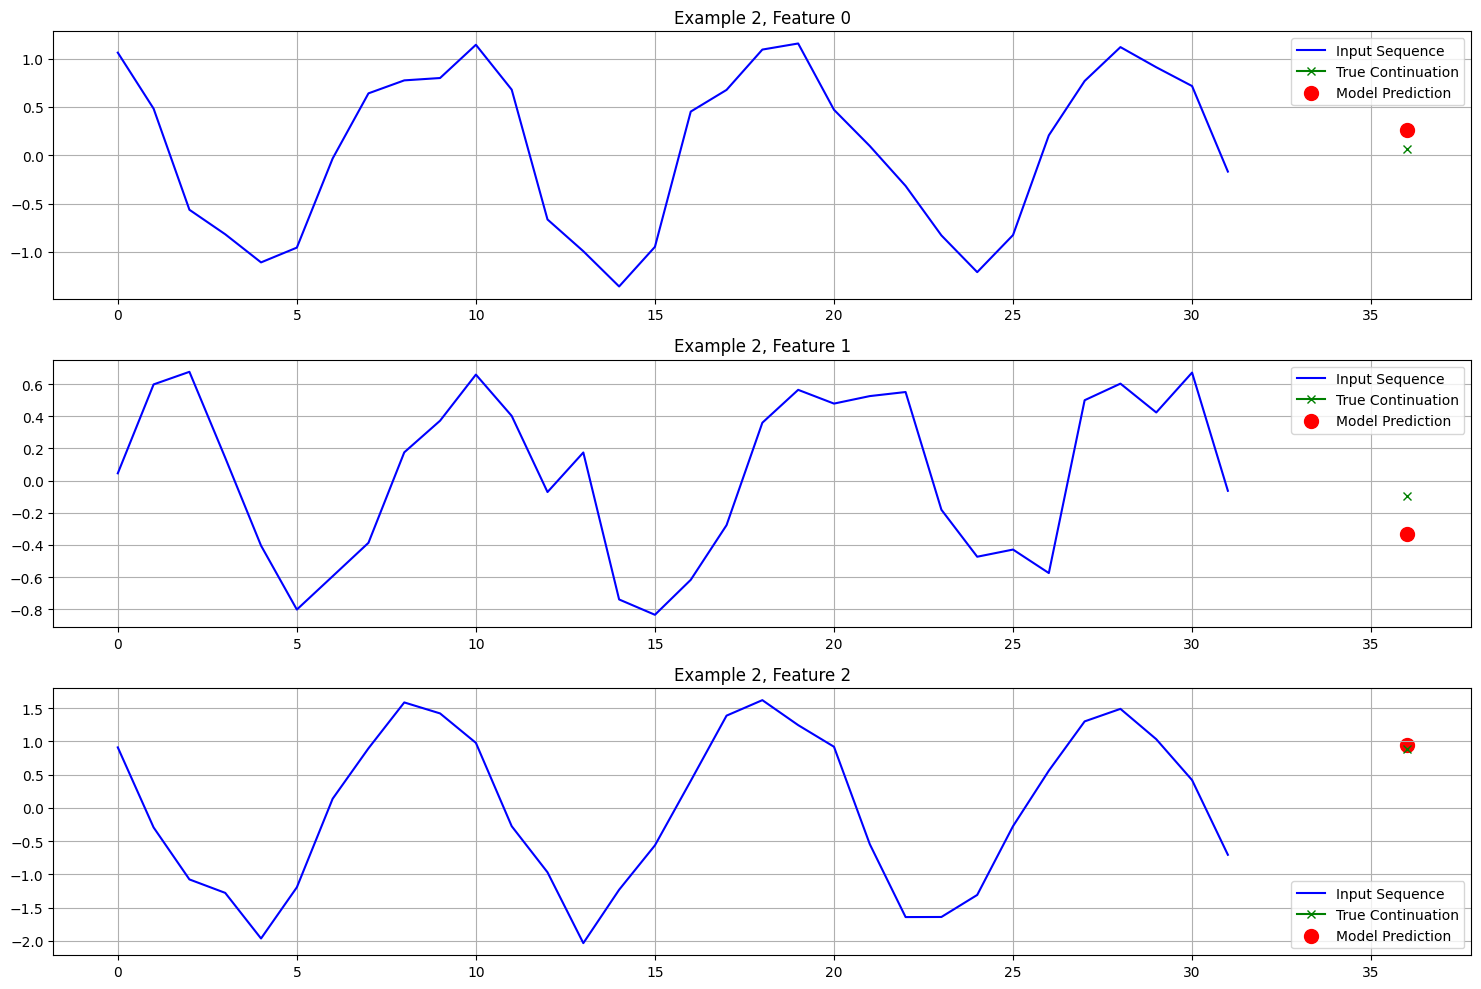

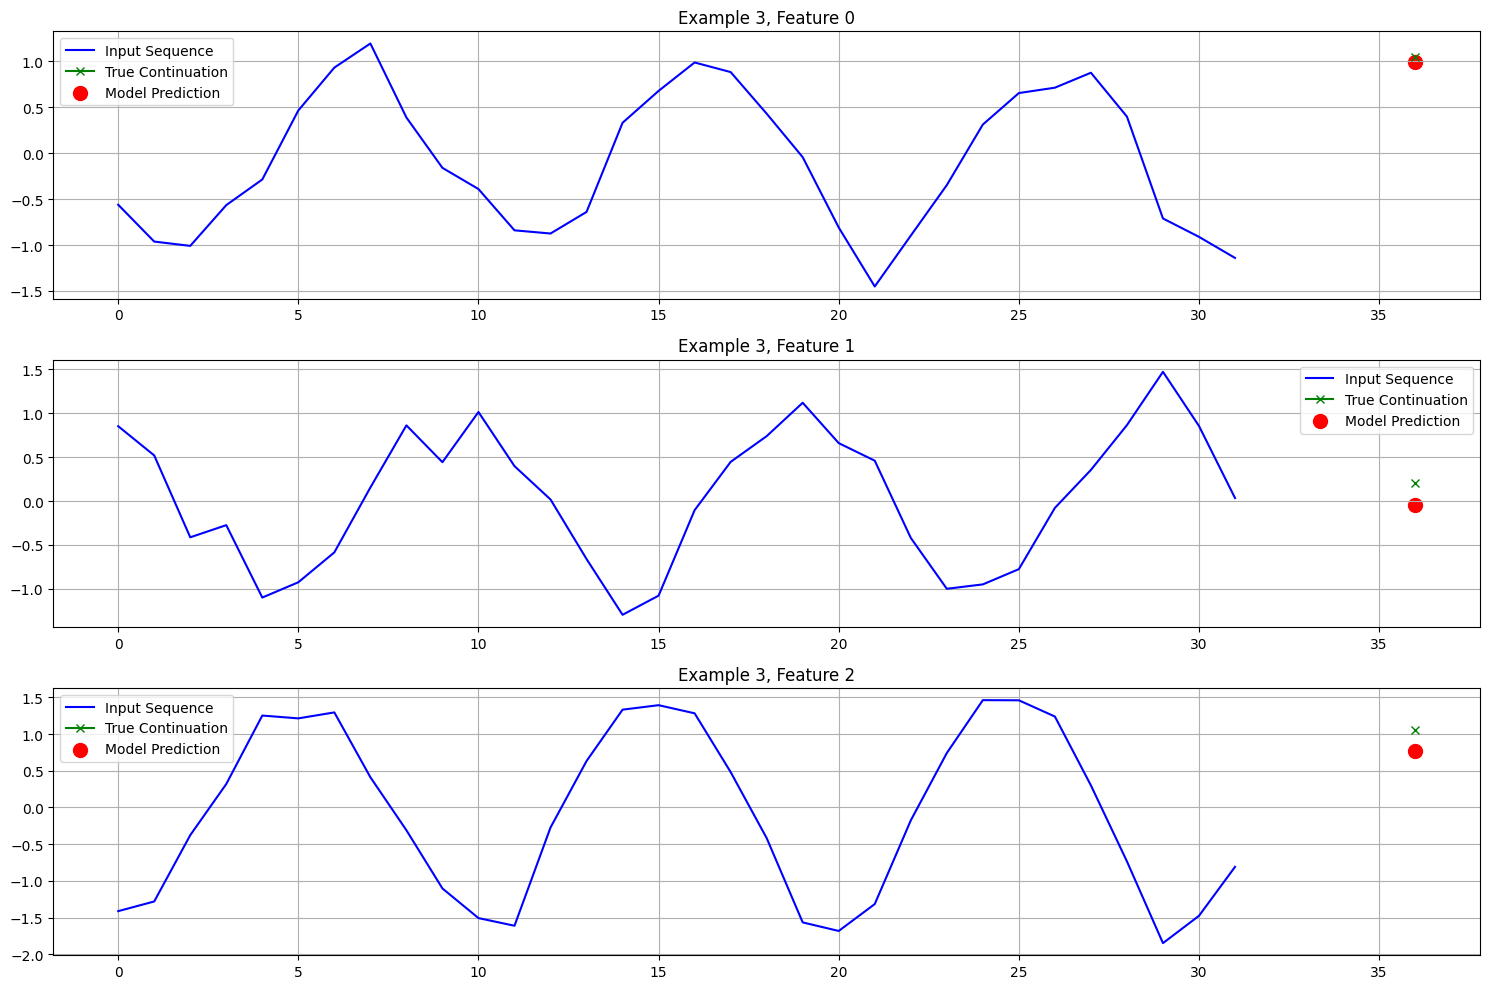

Data: (32, 3)
Predictions: (32, 3)


/tmp/ericfey1/27114675/ipykernel_541784/255876493.py:58: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(predictions[:,col], y[:,col],


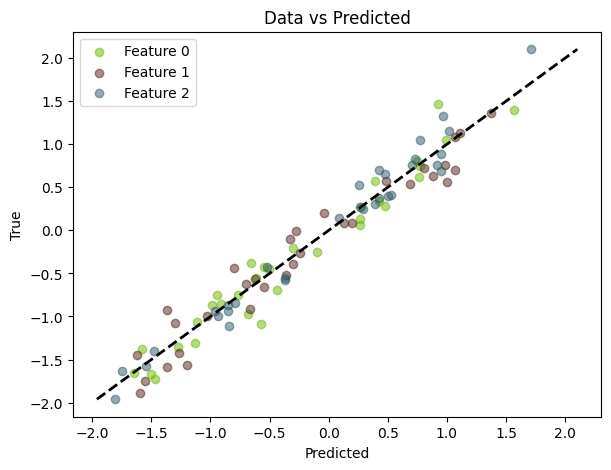

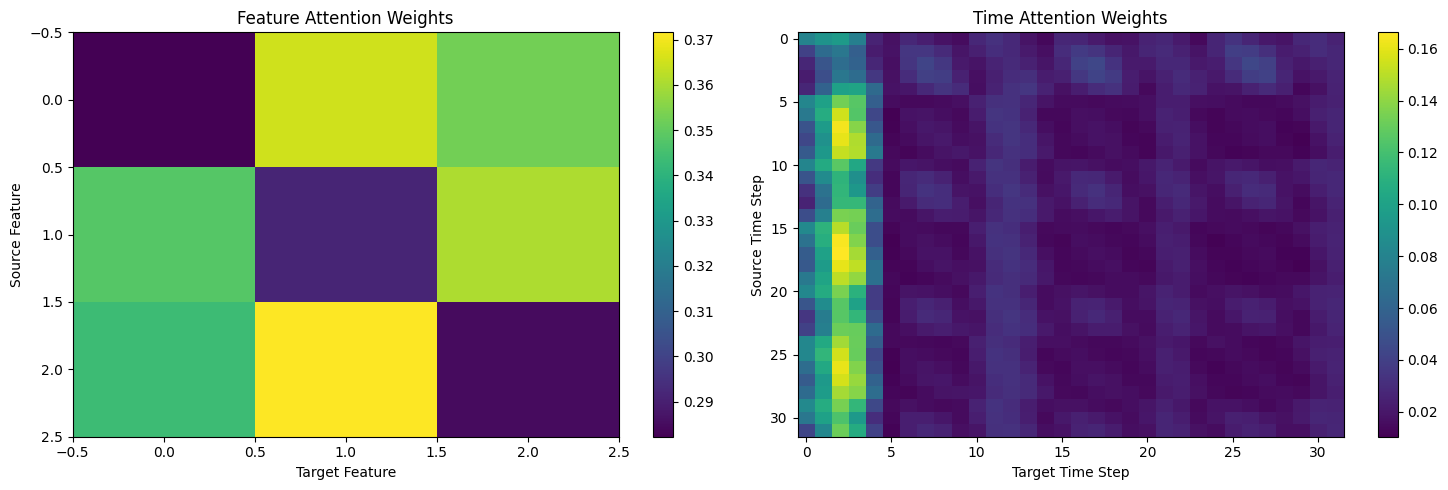

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def visualize_predictions(model, test_loader, device='cuda', num_examples=3):
    model.eval()

    # Get some test examples
    x, y = next(iter(test_loader))
    x, y = x.to(device), y.to(device)

    # Get predictions
    with torch.no_grad():
        predictions, feat_attn, time_attn = model(x)
        predictions = predictions.cpu().numpy()
        x = x.cpu().numpy()
        y = y.cpu().numpy()

    # Plot multiple features for a few examples
    for example_idx in range(min(num_examples, x.shape[0])):
        plt.figure(figsize=(15, 10))

        # Plot 3 different features
        for i, feature_idx in enumerate([0,1,2]):#([0, 7, 14]):  # Beginning, middle, and end features
            plt.subplot(3, 1, i+1)

            # Plot input sequence
            time_input = np.arange(x.shape[2])
            plt.plot(time_input, x[example_idx, feature_idx],
                    label='Input Sequence', color='blue')

            # Plot true continuation
            #time_target = np.arange(x.shape[2], x.shape[2] + y.shape[2])
            time_target = [x.shape[2] + 5 - 1]
            plt.plot(time_target, y[example_idx, feature_idx], "x-",
                    label='True Continuation', color='green')

            # Plot prediction
            plt.scatter(time_target[0], predictions[example_idx, feature_idx],
                       color='red', label='Model Prediction', s=100)

            plt.title(f'Example {example_idx + 1}, Feature {feature_idx}')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    # Plot data vs predicted & groundtruth vs predicted
    plt.figure(figsize=(15, 5))
    # data vs predicted
    plt.subplot(1, 2, 1)
    print(f"Data: {y.shape}")
    print(f"Predictions: {predictions.shape}")
    np.random.seed(1)
    for col in range(y.shape[1]):
      plt.scatter(predictions[:,col], y[:,col],
                  c=np.random.rand(3,), label=f'Feature {col}', alpha=0.5)
    # Add perfect line
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Data vs Predicted')
    plt.legend()

    # Visualize attention weights
    plt.figure(figsize=(15, 5))

    # Feature attention weights
    plt.subplot(1, 2, 1)
    feat_attn_avg = feat_attn.mean(dim=(0, 1)).cpu().numpy()
    plt.imshow(feat_attn_avg, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Feature Attention Weights')
    plt.xlabel('Target Feature')
    plt.ylabel('Source Feature')

    # Time attention weights
    plt.subplot(1, 2, 2)
    time_attn_avg = time_attn.mean(dim=(0, 1)).cpu().numpy()
    plt.imshow(time_attn_avg, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Time Attention Weights')
    plt.xlabel('Target Time Step')
    plt.ylabel('Source Time Step')

    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    criterion = torch.nn.MSELoss()
    total_mse = 0
    total_mae = 0
    num_batches = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            predictions, _, _ = model(x)

            # Calculate MSE and MAE
            #mse = criterion(predictions, y[:, :, 0])
            #mae = torch.abs(predictions - y[:, :, 0]).mean()
            mse = criterion(predictions, y)
            mae = torch.abs(predictions - y).mean()

            total_mse += mse.item()
            total_mae += mae.item()
            num_batches += 1

    avg_mse = total_mse / num_batches
    avg_mae = total_mae / num_batches

    print(f"Test Set Metrics:")
    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average MAE: {avg_mae:.4f}")
    print(f"RMSE: {np.sqrt(avg_mse):.4f}")

    return avg_mse, avg_mae

def main():
    # Parameters
    batch_size = 32
    n_samples = 1000
    n_features = 3
    sequence_length = 32
    prediction_length = 5

    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        batch_size=batch_size,
        n_samples=n_samples,
        n_features=n_features,
        sequence_length=sequence_length,
        prediction_length=prediction_length
    )

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DualAttentionModel(
        n_features=n_features,
        time_steps=sequence_length,
        d_model=128,
        n_heads=8,
        dropout=0.1
    ).to(device)

    # Load best model weights
    try:
        model.load_state_dict(torch.load('best_sine_model.pt'))
        print("Loaded best model weights successfully!")
    except:
        print("No saved model found. Please train the model first.")
        return

    # Evaluate model
    mse, mae = evaluate_model(model, test_loader, device)

    # Visualize results
    visualize_predictions(model, test_loader, device)

    # Save a timestamp of when these results were generated
    timestamp = "2025-03-01 10:01:16"  # Using the provided timestamp
    user = "eric-fey-hus"

    # Save results to a file
    with open('model_results.txt', 'w') as f:
        f.write(f"Results generated on: {timestamp}\n")
        f.write(f"Generated by user: {user}\n")
        f.write(f"Model Performance Metrics:\n")
        f.write(f"MSE: {mse:.4f}\n")
        f.write(f"MAE: {mae:.4f}\n")
        f.write(f"RMSE: {np.sqrt(mse):.4f}\n")

#if __name__ == "__main__":
main()

# DEPRECIATED - for learning/reference

In [10]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(-2)]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        seq_len = query.size(1)

        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)

        # Reshape to [batch, heads, seq_len, d_k]
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attention_weights = torch.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Apply attention to V
        output = torch.matmul(attention_weights, V)

        # Reshape back
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.W_o(output)

        return output, attention_weights

class DualAttentionModel(nn.Module):
    def __init__(self, n_features, time_steps, d_model=128, n_heads=8, dropout=0.1):
        super().__init__()

        self.d_model = d_model

        # Input projection
        self.input_projection = nn.Linear(1, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)

        # Feature attention
        self.feature_attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feature_norm = nn.LayerNorm(d_model)

        # Time attention
        self.time_attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.time_norm = nn.LayerNorm(d_model)

        # Output layers
        self.fc1 = nn.Linear(d_model, d_model)
        self.fc2 = nn.Linear(d_model, 1)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, x):
        # x shape: [batch_size, n_features, time_steps]
        batch_size, n_features, time_steps = x.shape

        # Add channel dimension and project
        x = x.unsqueeze(-1)  # [batch_size, n_features, time_steps, 1]
        x = self.input_projection(x)  # [batch_size, n_features, time_steps, d_model]

        # Add positional encoding
        x = self.pos_encoder(x)

        # Prepare for feature attention
        # Reshape to [batch_size * time_steps, n_features, d_model]
        x_feat = x.transpose(1, 2).reshape(batch_size * time_steps, n_features, self.d_model)

        # Feature attention
        x_feat, feat_weights = self.feature_attention(x_feat, x_feat, x_feat)

        # Reshape back and add residual
        x_feat = x_feat.view(batch_size, time_steps, n_features, self.d_model).transpose(1, 2)
        x = x + self.dropout(x_feat)
        x = self.feature_norm(x)

        # Prepare for time attention
        # Reshape to [batch_size * n_features, time_steps, d_model]
        x_time = x.reshape(batch_size * n_features, time_steps, self.d_model)

        # Time attention
        x_time, time_weights = self.time_attention(x_time, x_time, x_time)

        # Reshape back and add residual
        x_time = x_time.view(batch_size, n_features, time_steps, self.d_model)
        x = x + self.dropout(x_time)
        x = self.time_norm(x)

        # Global average pooling over time
        x = x.mean(dim=2)  # [batch_size, n_features, d_model]

        # Final prediction
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x).squeeze(-1)  # [batch_size, n_features]

        return x, feat_weights, time_weights

def test_model():
    # Example dimensions
    batch_size = 32
    n_features = 15
    time_steps = 10

    # Create random input data
    x = torch.randn(batch_size, n_features, time_steps)

    # Initialize model
    model = DualAttentionModel(
        n_features=n_features,
        time_steps=time_steps,
        d_model=128,
        n_heads=8,
        dropout=0.1
    )

    # Forward pass
    output, feat_attn, time_attn = model(x)

    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Feature attention weights shape: {feat_attn.shape}")
    print(f"Time attention weights shape: {time_attn.shape}")

    return model, output, feat_attn, time_attn

#if __name__ == "__main__":
model, output, feat_attn, time_attn = test_model()

Input shape: torch.Size([32, 15, 10])
Output shape: torch.Size([32, 15])
Feature attention weights shape: torch.Size([320, 8, 15, 15])
Time attention weights shape: torch.Size([480, 8, 10, 10])


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

def scaled_dot_product_attention(query, key, value, mask=None, dropout=None):
    """
    Scaled Dot-Product Attention mechanism

    Args:
        query (Tensor): Query tensor, shape [batch_size, n_heads, seq_len, d_k]
        key (Tensor): Key tensor, shape [batch_size, n_heads, seq_len, d_k]
        value (Tensor): Value tensor, shape [batch_size, n_heads, seq_len, d_v]
        mask (Tensor, optional): Mask tensor, shape [batch_size, 1, seq_len, seq_len]
        dropout (nn.Dropout, optional): Dropout layer

    Returns:
        Tensor: Attention output, shape [batch_size, n_heads, seq_len, d_v]
        Tensor: Attention weights, shape [batch_size, n_heads, seq_len, seq_len]
    """
    d_k = query.size(-1)

    # Compute attention scores
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    # Apply mask if provided
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

    # Apply softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)

    if dropout is not None:
        attention_weights = dropout(attention_weights)

    # Compute weighted sum of values
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention module

    Args:
        d_model (int): Model dimension
        n_heads (int): Number of attention heads
        dropout (float): Dropout probability
    """
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads  # Dimension of each head

        # Linear projections
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Linear projections and split into heads
        Q = self.W_q(query).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)

        # Apply mask to all heads if provided
        if mask is not None:
            mask = mask.unsqueeze(1)

        # Apply scaled dot-product attention
        output, attention_weights = scaled_dot_product_attention(Q, K, V, mask, self.dropout)

        # Concatenate heads and apply final linear projection
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(output)

        return output, attention_weights

class PositionalEncoding(nn.Module):
    """
    Positional Encoding module to add positional information to embeddings

    Args:
        d_model (int): Model dimension
        max_len (int): Maximum sequence length
        dropout (float): Dropout probability
    """
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [4]:
import torch
#from attention import MultiHeadAttention, PositionalEncoding

# Example parameters
batch_size = 32
seq_len = 100
d_model = 512
n_heads = 8

# Create sample input
x = torch.randn(batch_size, seq_len, d_model)

# Initialize modules
pos_encoding = PositionalEncoding(d_model)
multihead_attention = MultiHeadAttention(d_model, n_heads)

# Add positional encoding
x = pos_encoding(x)

# Apply multi-head attention (self-attention in this case)
output, attention_weights = multihead_attention(x, x, x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")  # [batch_size, seq_len, d_model]
print(f"Attention weights shape: {attention_weights.shape}")  # [batch_size, n_heads, seq_len, seq_len]

Input shape: torch.Size([32, 100, 512])
Output shape: torch.Size([32, 100, 512])
Attention weights shape: torch.Size([32, 8, 100, 100])


In [5]:
import torch
import math

def demonstrate_positional_encoding():
    # Example with small numbers for clarity
    max_len = 4
    d_model = 6

    # Create empty positional encoding matrix
    pe = torch.zeros(max_len, d_model)
    print("Initial pe shape:", pe.shape)
    print("Initial pe:\n", pe)

    # Create position vector
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    print("\nPosition shape:", position.shape)
    print("Position:\n", position)

    # Create frequency division terms
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    print("\nDiv_term shape:", div_term.shape)
    print("Div_term:\n", div_term)

    # Apply sin to even indices
    pe[:, 0::2] = torch.sin(position * div_term)
    print("\nAfter sin (even columns):\n", pe)

    # Apply cos to odd indices
    pe[:, 1::2] = torch.cos(position * div_term)
    print("\nAfter cos (odd columns):\n", pe)

    # Add batch dimension
    pe = pe.unsqueeze(0)
    print("\nFinal shape after unsqueeze:", pe.shape)
    print("Final pe:\n", pe)

demonstrate_positional_encoding()

Initial pe shape: torch.Size([4, 6])
Initial pe:
 tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

Position shape: torch.Size([4, 1])
Position:
 tensor([[0.],
        [1.],
        [2.],
        [3.]])

Div_term shape: torch.Size([3])
Div_term:
 tensor([1.0000, 0.0464, 0.0022])

After sin (even columns):
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8415, 0.0000, 0.0464, 0.0000, 0.0022, 0.0000],
        [0.9093, 0.0000, 0.0927, 0.0000, 0.0043, 0.0000],
        [0.1411, 0.0000, 0.1388, 0.0000, 0.0065, 0.0000]])

After cos (odd columns):
 tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000]])

Final shape after unsqueeze: torch.Size([1, 4, 6])
Final pe:
 tensor([[[ 0.0000,  1.00

In [6]:
import torch
import numpy as np

def demonstrate_broadcasting():
    print("1. Basic Broadcasting with Scalars:")
    # A scalar value is broadcast to match the tensor shape
    tensor = torch.ones(4, 3)
    scalar = 2
    result = tensor * scalar
    print(f"Shape of tensor: {tensor.shape}")  # torch.Size([4, 3])
    print(f"Result shape: {result.shape}")     # torch.Size([4, 3])
    print(f"Result:\n{result}\n")

    print("2. Broadcasting Rules with Different Shapes:")
    # Shapes are compared from right to left
    # Each dimension must be either:
    # 1. Equal, or
    # 2. One of them is 1, or
    # 3. One doesn't exist

    # Example 1: [4, 1] + [3] -> [4, 3]
    a = torch.ones(4, 1)
    b = torch.arange(3)
    result = a + b
    print(f"Shape a: {a.shape}")        # torch.Size([4, 1])
    print(f"Shape b: {b.shape}")        # torch.Size([3])
    print(f"Result shape: {result.shape}")  # torch.Size([4, 3])
    print(f"Result:\n{result}\n")

    print("3. More Complex Broadcasting:")
    # Example: [2, 1, 3] + [3] -> [2, 1, 3]
    x = torch.ones(2, 1, 3)
    y = torch.arange(3)
    result = x + y
    print(f"Shape x: {x.shape}")        # torch.Size([2, 1, 3])
    print(f"Shape y: {y.shape}")        # torch.Size([3])
    print(f"Result shape: {result.shape}")  # torch.Size([2, 1, 3])
    print(f"Result:\n{result}\n")

def show_broadcasting_steps():
    """
    Shows how broadcasting works step by step
    """
    print("Broadcasting Steps Visualization:")

    # Original shapes
    a = torch.ones(4, 1)    # [4, 1]
    b = torch.arange(3)     # [3]

    print("Step 1: Original shapes")
    print(f"a shape: {a.shape}")
    print(f"b shape: {b.shape}")

    # Step 2: Right alignment
    print("\nStep 2: Right align dimensions")
    print("a: [4, 1]")
    print("b:    [3]")

    # Step 3: Broadcasting
    print("\nStep 3: Broadcasting")
    print("a: [4, 1] -> [4, 3]  (1 is broadcast to 3)")
    print("b:    [3] -> [4, 3]  (3 is broadcast across 4 rows)")

    result = a + b
    print(f"\nFinal result shape: {result.shape}")

# Common broadcasting patterns
def common_broadcasting_patterns():
    print("Common Broadcasting Patterns:")

    # 1. Adding a vector to each row of a matrix
    matrix = torch.ones(3, 4)
    vector = torch.arange(4)
    result1 = matrix + vector
    print(f"1. Matrix {matrix.shape} + Vector {vector.shape} -> {result1.shape}")

    # 2. Adding a column vector to a matrix
    col_vector = torch.ones(3, 1)
    result2 = matrix + col_vector
    print(f"2. Matrix {matrix.shape} + Column {col_vector.shape} -> {result2.shape}")

    # 3. Outer product using broadcasting
    v1 = torch.arange(3).reshape(-1, 1)  # Column vector
    v2 = torch.arange(4).reshape(1, -1)  # Row vector
    outer_product = v1 * v2
    print(f"3. Outer product: {v1.shape} * {v2.shape} -> {outer_product.shape}")

demonstrate_broadcasting()
show_broadcasting_steps()
common_broadcasting_patterns()

1. Basic Broadcasting with Scalars:
Shape of tensor: torch.Size([4, 3])
Result shape: torch.Size([4, 3])
Result:
tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])

2. Broadcasting Rules with Different Shapes:
Shape a: torch.Size([4, 1])
Shape b: torch.Size([3])
Result shape: torch.Size([4, 3])
Result:
tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]])

3. More Complex Broadcasting:
Shape x: torch.Size([2, 1, 3])
Shape y: torch.Size([3])
Result shape: torch.Size([2, 1, 3])
Result:
tensor([[[1., 2., 3.]],

        [[1., 2., 3.]]])

Broadcasting Steps Visualization:
Step 1: Original shapes
a shape: torch.Size([4, 1])
b shape: torch.Size([3])

Step 2: Right align dimensions
a: [4, 1]
b:    [3]

Step 3: Broadcasting
a: [4, 1] -> [4, 3]  (1 is broadcast to 3)
b:    [3] -> [4, 3]  (3 is broadcast across 4 rows)

Final result shape: torch.Size([4, 3])
Common Broadcasting Patterns:
1. Matrix torch.Size([3, 4]) + Vector

In [11]:
    # Original shapes
    a = torch.ones(4, 1)    # [4, 1]
    b = torch.arange(3)     # [3]
    print(a)
    print(b)
    print(a+b)

tensor([[1.],
        [1.],
        [1.],
        [1.]])
tensor([0, 1, 2])
tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]])
